# Deploy a BQML customer churn propensity model to Vertex AI for online predictions

## Learning objectives

* Train a BQML classifier to predict customer churn.
* Evaluate the performance of a BQML classifier.
* Explain your model with BQML Explainable AI.
* Export a BQML model to Vertex AI Endpoint for online predictions.

## Introduction: customer propensity modeling in the mobile gaming industry

## Setup

### Define constants

In [5]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

In [6]:
BQ_REGION = 'US'

### Import libraries

In [7]:
from google.cloud import bigquery
import pandas as pd

### Create a BigQuery dataset

In [48]:
DATASET_NAME = 'bqmlga4'
!bq mk --location=$BQ_REGION --dataset $PROJECT_ID:$DATASET_NAME

BigQuery error in mk operation: Dataset 'dougkelly-vertex-demos:bqmlga4' already
exists.


## Exploratory Data Analysis (EDA) in BigQuery

In [5]:
# %%bigquery --project $PROJECT_ID

# SELECT 
#     *
# FROM
#   `firebase-public-project.analytics_153293282.events_*`
    
# TABLESAMPLE SYSTEM (1 PERCENT)

In [5]:
%%bigquery --project $PROJECT_ID

SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.47s/rows]


,count_distinct_users,count_events
0,15175,5700000


## Dataset preparation in BigQuery

### Defining churn for each user

In [13]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.returningusers AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    #add 24 hr to user's first touch
    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,

#churned = 1 if last_touch within 24 hr of app installation, else 0
IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,

#bounced = 1 if last_touch within 10 min, else 0
IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

SELECT 
  * 
FROM 
  bqmlga4.returningusers 
LIMIT 100;

Downloading: 100%|██████████| 100/100 [00:01<00:00, 70.95rows/s]


,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,EB925367B0DF557CA74ED0CC116F44A4,1535155709434023,1535156334511042,8,237,7,1535242109434023,1,0
1,A7993B3D9E693DFD3EA57CF4D1B8D00F,1535008569735000,1536403738937006,8,235,5,1535094969735000,0,0
2,C6612BDBF9E70C3C8A39B77FFA145CB8,1535018308676001,1535128615038021,8,235,5,1535104708676001,0,0
3,4BB019F8F6D1FE7BA78CA42A4698EF56,1532671432419001,1536928654663009,7,208,6,1532757832419001,0,0
4,49309C5759610DBF6C829C0D4AB23943,1529325314532002,1538583713424035,6,169,2,1529411714532002,0,0
...,...,...,...,...,...,...,...,...,...
95,1902BB4F5DE02DCCBE4C023121E13C3C,1533810075114001,1533810165020006,8,221,5,1533896475114001,1,1
96,BDD854D198AD34410E91C75C2ED5F525,1533866244084009,1533866464472034,8,222,6,1533952644084009,1,1
97,DF0E8F12B1AA38135A5448195EFEC25B,1533865529336001,1533866302593117,8,222,6,1533951929336001,1,0
98,B320BBAA94210EE1FAF12AFFCD1D580D,1531347307917011,1538609255678071,7,192,4,1531433707917011,0,0


In [14]:
%%bigquery --project $PROJECT_ID

SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.returningusers
GROUP BY 1,2
ORDER BY bounced

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.06rows/s]


,bounced,churned,count_users
0,0,0,6148
1,0,1,1883
2,1,1,5557


In [15]:
%%bigquery --project $PROJECT_ID

SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.returningusers
WHERE bounced = 0

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.56s/rows]


,churn_rate
0,0.234466


### Extract user demographic features

In [16]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.86rows/s]


,user_pseudo_id,country,operating_system,language
0,022FFC1F2B5A9F2982EE83C313176D54,Australia,IOS,en
1,08834EE61A695663A958731AFFAB1A10,United States,IOS,en-us
2,09F08BC9ABD1D8E3DC00A6C5EF24B67C,India,ANDROID,en-gb
3,0A0B3A969C027FAED144D9E15F0A2375,Canada,IOS,en-ca
4,0A1BE2DE5E8F994D51EB1D5E287843AB,United States,IOS,en-us
5,106780109A3D60E1D37A41399815B452,Germany,IOS,de-de
6,11DB5D83E83F7419B3B5352D56DD4ECC,United States,IOS,en-us
7,12158845DAB88DD2D8E951C24EF9CFF2,Israel,IOS,en-il
8,12DBA24E4CCF5441E94E1E1EF554CB9F,Japan,IOS,ja-jp
9,16535A918ADAE06E4E30A71918B6E92B,United States,ANDROID,en-us


### Aggregate user behavioral features

In [17]:
%%bigquery --project $PROJECT_ID

SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 1
ORDER BY
   event_count DESC

Downloading: 100%|██████████| 37/37 [00:01<00:00, 27.89rows/s]


,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


In [18]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior AS (
WITH
  events_first24hr AS (
    #select user data only from first 24 hr of using the app
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.returningusers r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      e.event_timestamp <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  1
  );

SELECT
  *
FROM
  bqmlga4.user_aggregate_behavior
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.63rows/s]


,user_pseudo_id,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps
0,0B57732CC81507A6EF8F49B7BEC5770F,6,0,0,0,0,1,0,0,0,0,0
1,1E2A3390D6264C290AC4EA3B8332EC37,53,1,0,0,0,7,2,0,0,0,0
2,FAD835B2685732F929BD039038406EC9,35,9,4,0,3,2,1,0,0,0,0
3,137944D29FEB9F2C96187C5F6604F5DB,24,0,0,0,0,6,0,0,0,1,0
4,B100E7D54CE769CF55AC6949A18EC4CE,96,33,23,11,0,11,0,0,0,0,0
5,3C3AFC055916156465DC1A481D9E9D04,9,2,1,0,1,0,0,0,0,0,0
6,9BE0C2F166FC43E3ED5FCCCD34EBF1D9,5,3,0,0,2,0,0,0,0,0,0
7,51BE9D34ED694DAE091F5EE883508323,3,1,1,1,0,1,0,0,0,0,0
8,E3210532BA0838094E646E12D714BFE2,12,1,0,0,0,0,0,0,0,0,0
9,477B10057CE20CBC8BCD3AD4F75BA95C,3,0,0,0,0,0,0,0,0,0,0


In [19]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.train AS (
    
  SELECT
    dem.*,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    ret.user_first_engagement,
    ret.month,
    ret.julianday,
    ret.dayofweek,
    ret.churned
  FROM
    bqmlga4.returningusers ret
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    ret.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_aggregate_behavior beh
  ON
    ret.user_pseudo_id = beh.user_pseudo_id
  WHERE ret.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.train
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.58rows/s]


,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned
0,85FD06F19EBB6097388EEE0B207598B7,United States,ANDROID,en-us,64,12,11,1,0,1,0,0,0,0,0,1529121975329001,6,167,7,0
1,5217AB1A454DAED6243E1C9818BE6A20,United States,ANDROID,en-us,89,0,0,0,0,27,0,0,0,1,1,1529861523949001,6,175,1,0
2,0D6A346C85BF606BE12F9A70FC20A7B7,United Kingdom,ANDROID,en-gb,22,2,1,1,0,7,0,0,0,0,0,1530725394670005,7,185,4,0
3,920DB84FCC0F4421650B9E257E33180B,Sweden,ANDROID,sv-se,7,3,2,2,0,2,1,0,0,0,1,1528957982564003,6,165,5,0
4,2FC7AA16D54B177F0A2911FEA105A0B3,Greece,ANDROID,el-gr,4,1,1,0,0,0,0,0,0,0,0,1529749852064003,6,174,7,0
5,84D185835F0DE9C48712855B8713996E,United States,ANDROID,en-us,11,2,1,0,0,0,0,0,2,0,0,1529579468237008,6,172,5,0
6,0939A5A6511211C939F2C5E2FC7A569A,India,ANDROID,en-in,58,0,0,0,0,6,0,0,0,1,0,1532106669315005,7,201,6,0
7,B79F414B574CB7F894FE7236A1465837,United States,ANDROID,en-us,5,2,1,1,0,1,0,0,0,0,0,1531072151598005,7,189,1,0
8,117AD1627465CC9E03AB5D8825D42E07,Germany,ANDROID,de-de,11,5,5,5,0,5,0,0,0,0,0,1529228962548004,6,168,1,0
9,7DBEEB7A2488FE1FFC0808686AC09606,India,ANDROID,en-gb,22,10,8,8,2,8,0,0,0,0,0,1531332824513008,7,192,4,0


## Train a BQML propensity model to predict customer churn

In [53]:
MODEL_NAME='churn_xgb'

In [34]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  INPUT_LABEL_COLS=["churned"],
  ENABLE_GLOBAL_EXPLAIN=True
) AS

SELECT
  * EXCEPT(user_pseudo_id)
FROM
  bqmlga4.train

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1760.09query/s]                        


""


## Evaluate BQML model performance

In [35]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_xgb)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.39s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.603306,0.197832,0.784596,0.297959,0.441797,0.790885


In [36]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.37rows/s]


,expected_label,predicted_0,predicted_1
0,0,1180,48
1,1,296,73


In [37]:
%%bigquery df_roc --project $PROJECT_ID
SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_xgb)

Downloading: 100%|██████████| 91/91 [00:01<00:00, 63.03rows/s]


<AxesSubplot:title={'center':'AUC-ROC curve'}, xlabel='false_positive_rate'>

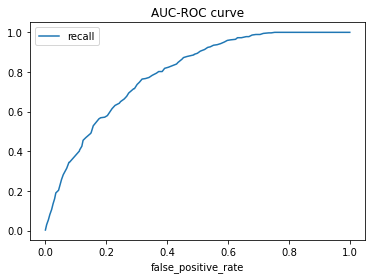

In [38]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

## Generate batch predict and explanations

In [39]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.train)) 

Downloading: 100%|██████████| 8031/8031 [00:01<00:00, 6236.81rows/s]


,predicted_churned,predicted_churned_probs,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,...,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned
0,0,"[{'label': 1, 'prob': 0.09748425334692001}, {'...",D421E51FE6DBCC2D91906B185509AB57,United States,ANDROID,en-us,7,2,2,1,...,0,0,0,0,0,1529800637906004,6,175,1,0
1,0,"[{'label': 1, 'prob': 0.3510470986366272}, {'l...",4EA4BB597E4AFD7B452F7C8669B5AC13,India,ANDROID,gu-in,57,0,0,0,...,1,0,0,1,1,1531450424744001,7,194,6,0
2,0,"[{'label': 1, 'prob': 0.3510470986366272}, {'l...",5B61E68C19B230022782F14E60F1EFA9,United Kingdom,ANDROID,en-gb,134,0,0,0,...,0,0,0,3,0,1531688409855007,7,196,1,1
3,0,"[{'label': 1, 'prob': 0.10274526476860046}, {'...",E6FEE8B98E75EA5311FE004F98559A27,United States,ANDROID,en-us,26,10,9,0,...,0,0,0,0,0,1529382024104009,6,170,3,0
4,0,"[{'label': 1, 'prob': 0.2232876420021057}, {'l...",06620D97BAC22D30DDE66F80BC5E7EA3,United States,ANDROID,en-us,13,4,2,1,...,0,0,0,0,0,1530766263429001,7,186,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8026,0,"[{'label': 1, 'prob': 0.24286527931690216}, {'...",1CE53B7BFD311B79EBE02347FAA21B4C,Bangladesh,ANDROID,en-gb,11,4,1,0,...,0,0,0,0,0,1536177227510003,9,248,4,1
8027,0,"[{'label': 1, 'prob': 0.3305028975009918}, {'l...",E67AAD89794950F36FFE36E8DA277021,India,ANDROID,en-gb,13,0,0,0,...,0,0,0,0,0,1536204403041001,9,249,5,1
8028,0,"[{'label': 1, 'prob': 0.3258748948574066}, {'l...",8B9934BC891E0F96EE43914E6EF11A7E,Mexico,IOS,en-fr,84,7,6,3,...,10,0,0,1,10,1536168949822001,9,248,4,1
8029,0,"[{'label': 1, 'prob': 0.24824270606040955}, {'...",0B986C511C4A24115798B4749E27F775,United Kingdom,IOS,en-gb,12,3,2,0,...,0,0,0,0,0,1536177124934000,9,248,4,1


In [40]:
%%bigquery --project $PROJECT_ID

SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.train))

Downloading: 100%|██████████| 8031/8031 [00:02<00:00, 3029.24rows/s]


,user_pseudo_id,churned,predicted_churned,probability_churned
0,CF2898B41B7243671C36D5168D9D89B0,0,0,0.080457
1,9B80883ACDC4F72515FCE888EC4C6A74,0,0,0.055687
2,85FD06F19EBB6097388EEE0B207598B7,0,0,0.031636
3,5217AB1A454DAED6243E1C9818BE6A20,0,0,0.228671
4,A7A49205CD47D898DE1536C9FEFD49F0,0,0,0.051135
...,...,...,...,...
8026,8E8FC0ABAB4F236EB8A332436DD4ADED,1,0,0.171074
8027,434B79A24E73A32E488354A1AAD98495,1,0,0.403762
8028,370BAFBB7AFD77B12726F4712DB42DF8,1,1,0.710525
8029,B5FFB2BC424A23635F872F45A78A0948,1,0,0.361524


In [41]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL bqmlga4.churn_xgb)

Downloading: 100%|██████████| 18/18 [00:01<00:00, 13.23rows/s]


,feature,attribution
0,cnt_user_engagement,0.283014
1,user_first_engagement,0.126458
2,julianday,0.109747
3,operating_system,0.081225
4,cnt_level_end_quickplay,0.042686
5,cnt_level_start_quickplay,0.037337
6,cnt_post_score,0.028005
7,language,0.015825
8,cnt_level_reset_quickplay,0.015175
9,cnt_level_complete_quickplay,0.012554


## Export a BQML model to Vertex AI for online predictions

In [72]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model 'dougkelly-vertex-demos:bqmlga4.churn_xgb' \
'gs://dougkelly-vertex-demos-bucket/churn_xgb'

Waiting on bqjob_r7b93b98c51a5ce57_0000017b19317a1a_1 ... (3s) Current status: DONE   


### Deploy a Vertex `Endpoint` for online predictions